In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4.

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)       
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu),stddev=4.0)
    return mu + tf.exp(log_var / 2) * eps

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))  
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2)))*1e-7
    
    return loss_temp


def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, height/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, height/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, height/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, height/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.tanh(h4)
    return prob

def Q(X):    
#     h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
#     z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
#     z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
#     return z_mu, z_logvar


    h1 = tf.nn.relu(tf.add(conv2d(tf.reshape(X,[mb_size, width/1, height/1, 1]),
                                  conv1_weight, stride=2, padding='SAME'),conv1_bias))
    
    h2 = tf.nn.relu(tf.add(conv2d(tf.reshape(h1,[mb_size, width/2, height/2, 32]),
                                  conv2_weight, stride=2, padding='SAME'),conv2_bias))
    
    
    h3 = tf.nn.relu(tf.matmul(tf.reshape(h2,[mb_size,width/4*height/4*64]), Q_W1) + Q_b1)
    
    z_mu = tf.matmul(h3, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h3, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

In [2]:
######## loading input data ########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import h5py
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


images = np.array(sio.loadmat('alloy_mat/sandstone_v2.mat')['Data'],dtype='float32')
images_L = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young.mat')['L'],dtype='float32')
images=images[0:760]

mb_size = 20
X_dim = images.shape[1]
width = 128
height = 128
h_dim = width/4*height/4
z_dim = 128/4


conv1_features=64
conv2_features=32
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64
num_channels_3=32
lr = 1e-3


# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

style_array = np.zeros([760,height,width,3])
style_array[:,:,:,0]=(images.reshape(760,height,width))*255
style_array[:,:,:,1]=(images.reshape(760,height,width))*255
style_array[:,:,:,2]=(images.reshape(760,height,width))*255
print(style_array.shape)


Using TensorFlow backend.


(760, 128, 128, 3)


In [3]:
######## weights & bias loaading ########
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [4]:
# =============================== Q(z|X) ======================================

z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, height, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

conv1_weight = tf.Variable(tf.truncated_normal([4, 4, 1, 32],
                                               stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([32], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, 32,64],
                                               stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([64], dtype=tf.float32))


# Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
# Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W1 = tf.Variable(xavier_init([X_dim*64/4/4, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [5]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))



In [6]:
# =============================== Middel Results ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)


In [7]:
######## style transfer ########
combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*255
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [8]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [9]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [10]:
# =============================== latent to Young's Module ====================================
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with linear activation
    out_layer = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([z_dim, z_dim/4])),
    'h2': tf.Variable(tf.random_normal([z_dim/4, 1])),
}

biases = {
    'b1': tf.Variable(tf.random_normal([z_dim/4])),
    'b2': tf.Variable(tf.random_normal([1])),
}

label = tf.placeholder(tf.float32, shape=[None, 1])
pred = multilayer_perceptron(z_sample, weights, biases)

In [11]:
# =============================== Cost ====================================

# Style transfer
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out7_S,conv_out7)
sl4 = style_loss(conv_out10_S,conv_out10)
sl = sl1 + sl2 + sl3 + sl4

# Young's modulus cost
Young_cost = tf.reduce_mean(tf.square(pred - label))

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss + Young_cost + sl)

In [14]:
import random
solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()
for it in range(100000):
    X_mb = images[(it*mb_size)%760:(it*mb_size)%760+mb_size]
    Y_L = images_L[(it*mb_size)%760:(it*mb_size)%760+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, Young_E, sl_E = sess.run([solver, vae_loss, recon_loss, kl_loss, Young_cost, sl], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              label:Y_L.reshape(mb_size,1),
                                                              style_image: style_array_input.reshape(mb_size,128,128,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('sl_E:{}'.format(sl_E))
        
        print()


Iter: 0
Loss: 4951.17285156
recon_E:2762.82836914
kl_E:0.63589990139
Young_E:990.383056641
sl_E:1197.32531738
()
Iter: 200
Loss: 1288.01123047
recon_E:488.816802979
kl_E:74.5970840454
Young_E:8.5598192215
sl_E:716.037597656
()
Iter: 400
Loss: 908.866271973
recon_E:440.196289062
kl_E:77.3631896973
Young_E:1.67830181122
sl_E:389.628540039
()
Iter: 600
Loss: 588.315917969
recon_E:369.06060791
kl_E:78.4120941162
Young_E:2.22036075592
sl_E:138.622802734
()
Iter: 800
Loss: 715.519348145
recon_E:381.331512451
kl_E:84.2069244385
Young_E:0.804864883423
sl_E:249.176025391
()
Iter: 1000
Loss: 726.724121094
recon_E:436.472595215
kl_E:86.6412658691
Young_E:1.62196493149
sl_E:201.988265991
()
Iter: 1200
Loss: 720.590515137
recon_E:334.20892334
kl_E:84.0320739746
Young_E:1.35538446903
sl_E:300.994140625
()
Iter: 1400
Loss: 690.297607422
recon_E:386.111083984
kl_E:87.3123245239
Young_E:1.12518179417
sl_E:215.749038696
()
Iter: 1600
Loss: 671.370300293
recon_E:347.906555176
kl_E:70.4048233032
Young_E:3

KeyboardInterrupt: 

In [106]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(100000):
    X_mb = images[(it*mb_size)%760:(it*mb_size)%760+mb_size]
    Y_L = images_L[(it*mb_size)%760:(it*mb_size)%760+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]*1.0
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, Young_E, sl_E = sess.run([solver, vae_loss, recon_loss, kl_loss, Young_cost, sl], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              label:Y_L.reshape(mb_size,1),
                                                              style_image: style_array_input.reshape(mb_size,128,128,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('sl_E:{}'.format(sl_E))
        
        print()

Iter: 0
Loss: 393.494598389
recon_E:212.080474854
kl_E:98.3449478149
Young_E:0.0588602945209
sl_E:83.010307312
()
Iter: 200
Loss: 406.218902588
recon_E:212.362457275
kl_E:99.1777191162
Young_E:0.0835661143064
sl_E:94.5951843262
()
Iter: 400
Loss: 413.096862793
recon_E:222.707763672
kl_E:100.205688477
Young_E:0.0486062690616
sl_E:90.1348114014
()
Iter: 600
Loss: 680.111572266
recon_E:205.517486572
kl_E:93.5729141235
Young_E:0.0571399740875
sl_E:380.964019775
()
Iter: 800
Loss: 364.776306152
recon_E:200.702789307
kl_E:100.245323181
Young_E:0.0743958353996
sl_E:63.7537727356
()
Iter: 1000
Loss: 738.663574219
recon_E:226.90713501
kl_E:106.870101929
Young_E:0.0434743091464
sl_E:404.842895508
()


KeyboardInterrupt: 

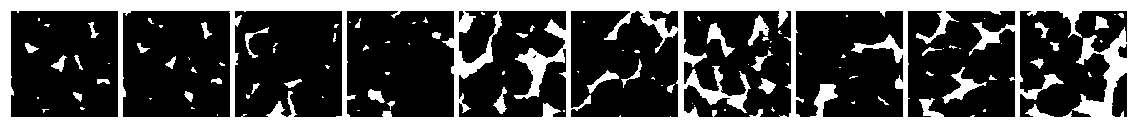

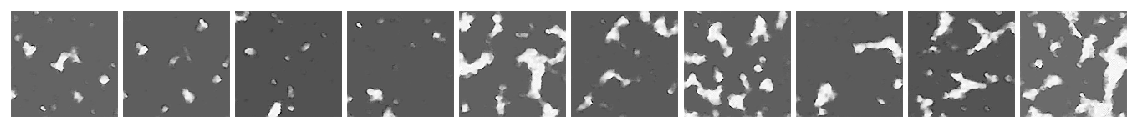

In [107]:
%matplotlib inline
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                 label:Y_L.reshape(mb_size,1)})
plot(images[0:10])
plot(recon[0:10])

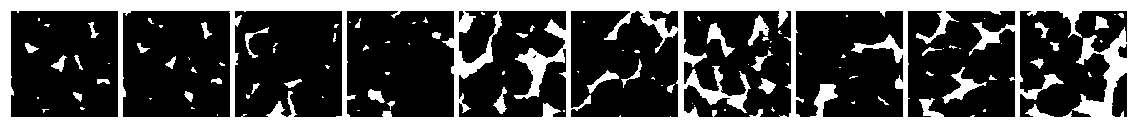

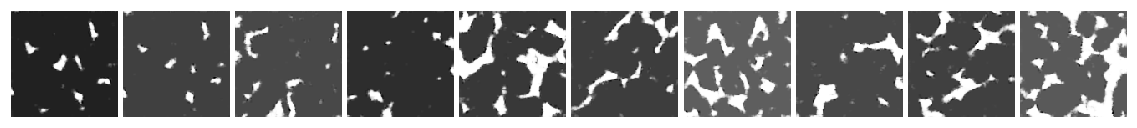

In [96]:
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                 label:Y_L.reshape(mb_size,1)})
plot(images[0:10])
plot(recon[0:10])

(array([   4.,    6.,   32.,   87.,  143.,  164.,  129.,   52.,   18.,    5.]),
 array([-2.443537  , -1.96993847, -1.49633994, -1.02274141, -0.54914289,
        -0.07554436,  0.39805417,  0.8716527 ,  1.34525123,  1.81884975,
         2.29244828]),
 <a list of 10 Patch objects>)

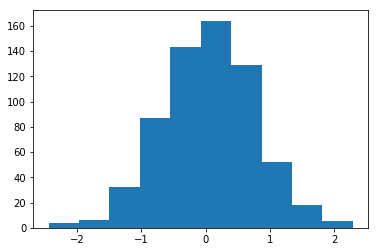

In [105]:
X_mb = images[0:20]
latent_z = sess.run(z_sample,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
plt.hist(latent_z.reshape(-1))

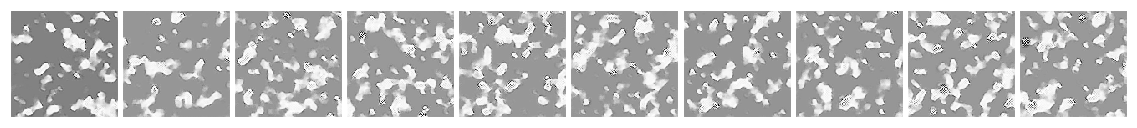

In [109]:
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
plot(samples[0:10])

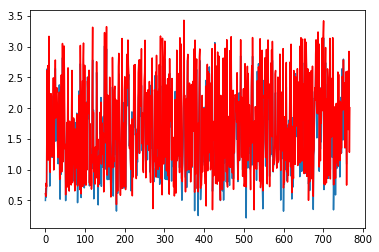

In [111]:
Y_pred_store_temp=[]
for it in range(760/mb_size):
    X_mb = images[(it*mb_size)%760:(it*mb_size)%760+mb_size]
    Y_pred = sess.run(pred, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
    Y_pred_store_temp.append(Y_pred)
Y_pred_store=[]
for i in range(38):
    for j in range(20):
        Y_pred_store.append(Y_pred_store_temp[i][j])
plt.plot(Y_pred_store)
plt.plot(images_L,'red')

In [52]:
Y_pred

array([[ 1.17296624],
       [ 1.50650644],
       [ 1.191401  ],
       [ 1.87525105],
       [ 1.21899223],
       [ 2.40866828],
       [ 1.25412464],
       [ 2.18836641],
       [ 2.58280611],
       [ 2.51806402],
       [ 1.69384885],
       [ 2.91648388],
       [ 2.04281211],
       [ 2.30162668],
       [ 1.42576241],
       [ 1.69957685],
       [ 1.87291408],
       [ 2.65011454],
       [ 2.03377318],
       [ 1.01747346]], dtype=float32)

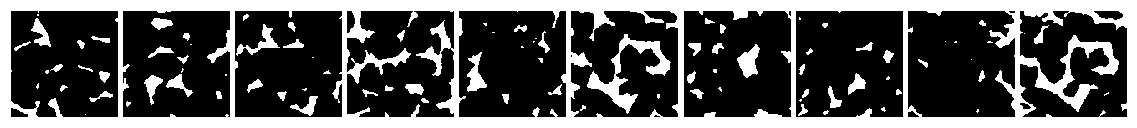

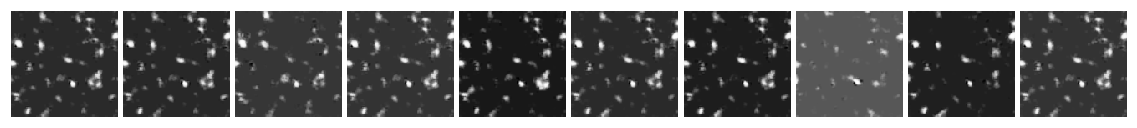

In [142]:
# =============================== Validation ====================================
images_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_test.mat')['Data'],dtype='float32')
images_L_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')

X_mb_test=images_test[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb_test.reshape(mb_size, width, height, num_channels_1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(X_mb_test[0:10])
plot(sample_temp[0:10])

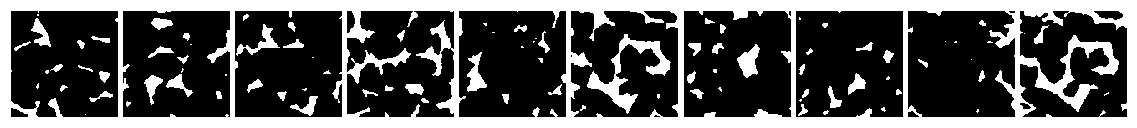

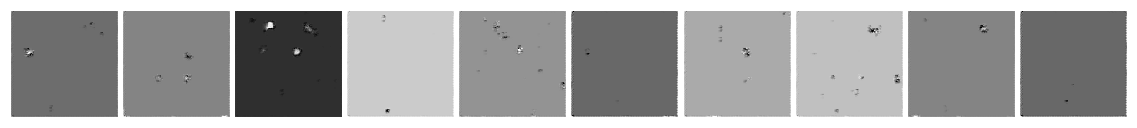

In [112]:
# =============================== Validation ====================================
%matplotlib inline
images_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_test.mat')['Data'],dtype='float32')
images_L_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')

X_mb_test=images_test[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb_test.reshape(mb_size, width, height, num_channels_1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(X_mb_test[0:10])
plot(sample_temp[0:10])

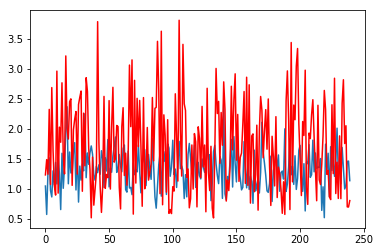

In [120]:
Y_pred_store_temp=[]
for it in range(240/mb_size):
    X_mb = images_test[(it*mb_size)%240:(it*mb_size)%240+mb_size]
    Y_pred = sess.run(pred, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
    Y_pred_store_temp.append(Y_pred)
Y_pred_store=[]
for i in range(240/20):
    for j in range(20):
        Y_pred_store.append(Y_pred_store_temp[i][j])
plt.plot(Y_pred_store)
plt.plot(images_L_test,'red')   

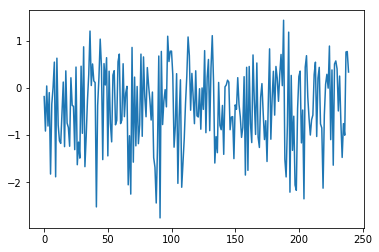

In [121]:
plt.plot(Y_pred_store-images_L_test)